<a href="https://colab.research.google.com/github/alenacode/testData/blob/master/SG_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

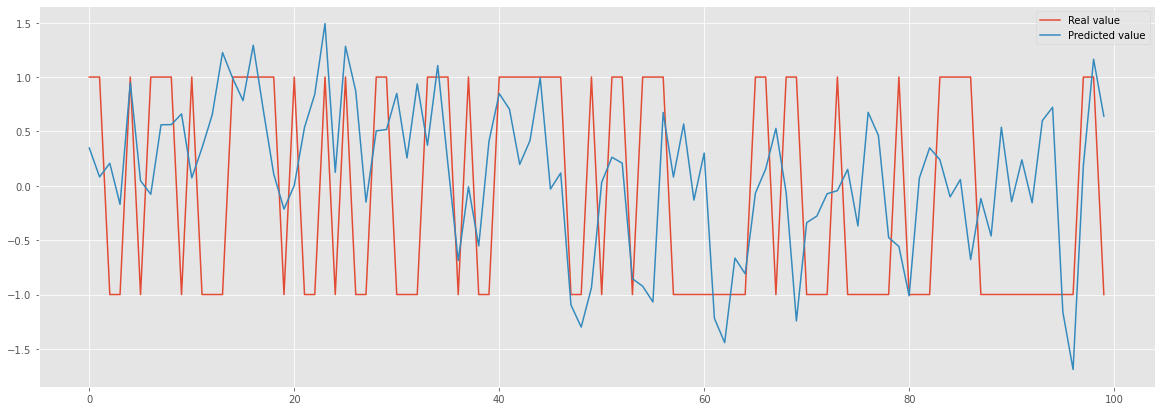

In [6]:
# multivariate multi-step encoder-decoder lstm 
%matplotlib inline
import matplotlib.pyplot as plt
import keras
from numpy import array, hstack, vstack
from keras.models import Sequential
from keras.layers import RepeatVector, LSTM, Dense, TimeDistributed
from sklearn.model_selection import train_test_split


# get configurations from file
def get_data():
    configs = []
    with open("/content/data.txt", "r") as dataFile:
        config = []
        for line in dataFile:
            config = [int(x) for x in line.split()]
            configs.append(config)
    return vstack(configs)


# split a multivariate sequence into samples
def split_sequences(dataset, num_of_timestamps, num_of_predictions):
    X, Y = list(), list()
    for i in range(len(dataset)):
        # find the end of this pattern
        end_ix = i + num_of_timestamps
        out_end_ix = end_ix + num_of_predictions
        # check if we are beyond the dataset
        if out_end_ix > len(dataset):
            break

        # gather input and output parts of the pattern
        seq_x, seq_y = dataset[i:end_ix], dataset[end_ix:out_end_ix]
        X.append(seq_x)
        Y.append(seq_y)
    return array(X), array(Y)


# horizontally stack columns
data = get_data()

# choose a number of time steps (1 - сколько мы будем брать конфигураций для каждого шага LSTM, 
#								 2 - на сколько шагов вперед хотим предсказать)
num_of_timestamps, num_of_predictions = 3, 2

# covert into input/output
X, Y = split_sequences(data, num_of_timestamps, num_of_predictions)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
features = X_train.shape[2]

# define model
model = Sequential()
model.add(LSTM(64, activation = 'tanh', input_shape = (num_of_timestamps, features)))
model.add(RepeatVector(num_of_predictions))
model.add(LSTM(64, activation = 'tanh', return_sequences = True))
model.add(TimeDistributed(Dense(features)))
model.compile(optimizer = 'adam', loss = 'mse')

# fit model
model.fit(X_train, Y_train, epochs = 300, verbose = 0)

# demonstrate prediction
prediction = model.predict(X_test)
plt.style.use('ggplot')
plt.figure(figsize=(20, 7))
plt.plot(Y_test.ravel()[:100], label="Real value")
plt.plot(prediction.ravel()[:100], label="Predicted value")
plt.legend()
